## 1. Redução da mortalidade de transito nos USA
<p><img src="https://assets.datacamp.com/production/project_462/img/car-accident.jpg" alt></p>
<p>Embora a taxa de acidentes de transito está diminuindo nos ultimos 80 anos, nos 10 ultimos anos houve uma estagnação nesse declinio. com o aumento de numero de milhas percorridas nas estradas dos estados unidos, está havendo um pequeno aumento no total de fatalidades nos ultimos 10 anos.</p>
<p>Para ajudar o departamento de transito dos USA seria interessante fazer uma investigação para determinar o que está causando esse aumento de acidentes. temos diante de nos os dados dos acidentes de transito por estados, por mais que haja muita variancia nos dados talvez exista algum padrão. o que seria bastante util para o departamento de transito saber quais esses padrões para poder aplicar politicas preventivas por estados semelhantes</p>
<p>Para realizar essa tarefa, é necessario fazer uma pequena limpeza dos dados, plotagem, redução da dimensionalidade e agrupar por uma tecnica de aprendizado de maquina não supervisionado</p>
<p>Os dados que nos foram fornecidos foram originalmente coletados pela National Highway Traffic Safety Administration e pela National Association of Insurance Commissioners. Esse conjunto de dados específico foi compilado e lançado como um <a href="https://github.com/fivethirtyeight/data/tree/master/bad-drivers">arquivo CSV</a> por FiveThirtyEight sob o <a href= "https://github.com/fivethirtyeight/data">licença CC-BY4.0</a>.</p>

## 2. Lendo e olhando de forma geral os dados
<p>Conhecendo um pouco dos dados que estamos lidando.</p>

In [1]:
# importando pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# read `road-accidents.csv`
car_acc = pd.read_csv('road-accidents.csv',comment='#',sep='|')

# mostrando coluans e linhas
rows_and_cols = car_acc.shape
print('There are {} rows and {} columns.\n'.format(
    rows_and_cols[0], rows_and_cols[1]))

# vizualizando o dataset
car_acc_information = car_acc.info()
print(car_acc_information)

# mostrando algumas colunas
car_acc.tail()

There are 51 rows and 5 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 51 non-null     object 
 1   drvr_fatl_col_bmiles  51 non-null     float64
 2   perc_fatl_speed       51 non-null     int64  
 3   perc_fatl_alcohol     51 non-null     int64  
 4   perc_fatl_1st_time    51 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB
None


,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
46,Virginia,12.7,19,27,88
47,Washington,10.6,42,33,86
48,West Virginia,23.8,34,28,87
49,Wisconsin,13.8,36,33,84
50,Wyoming,17.4,42,32,90


## 3. Resumo estatistico e grafico
<p>Agora temos uma ideia de como é o conjunto de dados. Para nos familiarizarmos ainda mais com esses dados, calcularemos estatísticas resumidas e produziremos uma visão geral gráfica dos dados. A visão geral gráfica é boa para ter uma noção da distribuição de variáveis ​​dentro dos dados e pode consistir em um histograma por coluna. Muitas vezes, é uma boa ideia explorar também a relação de pares entre todas as colunas no conjunto de dados usando um gráfico de dispersão de pares (às vezes chamado de "matriz de gráfico de dispersão")</p>

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
count,51.000000,51.000000,51.000000,51.00000
mean,15.790196,31.725490,30.686275,88.72549
std,4.122002,9.633438,5.132213,6.96011
min,5.900000,13.000000,16.000000,76.00000
25%,12.750000,23.000000,28.000000,83.50000
50%,15.600000,34.000000,30.000000,88.00000
75%,18.500000,38.000000,33.000000,95.00000
max,23.900000,54.000000,44.000000,100.00000


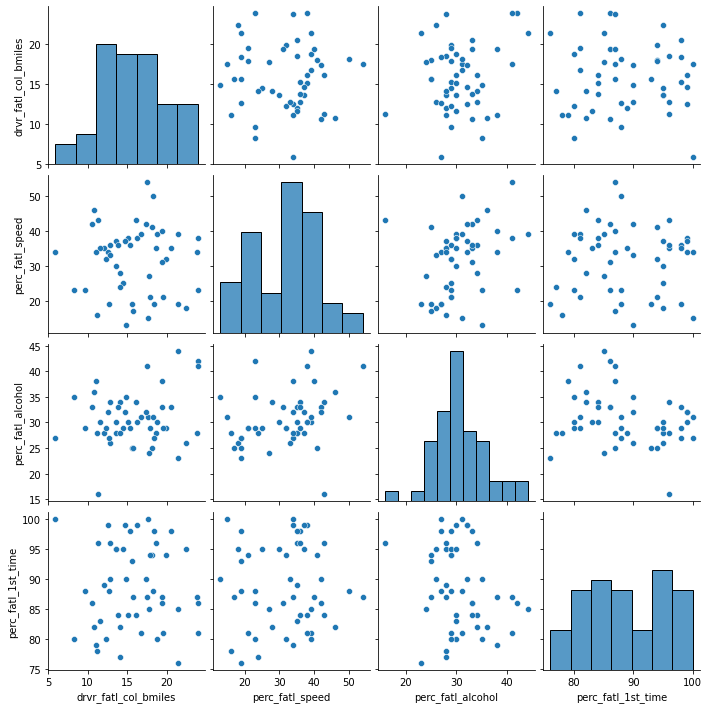

In [2]:
# descrição estatistica das colunas
sum_stat_car = car_acc.describe()
display(sum_stat_car)

# criando um grafico pairwise para explorar as variaveis
sns.pairplot(car_acc);

## 4. Correlação entre features
<p>Já podemos ver algumas relações potencialmente interessantes entre a variável de destino (o número de acidentes fatais) e as variáveis ​​de recurso (as três colunas restantes).</p>
<p>Para quantificar as relações de pares que observamos nos gráficos de dispersão, podemos calcular a matriz do coeficiente de correlação de Pearson. O coeficiente de correlação de Pearson é um dos métodos mais comuns para quantificar a correlação entre variáveis ​​e, por convenção, geralmente são usados ​​os seguintes limites:</p>
<ul>
<li>0.2 = fraco</li>
<li>0.5 = médio</li>
<li>0.8 = forte</li>
<li>0.9 = muito forte</li>
</ul>

In [3]:
# correlação entre as colunas
corr_columns = car_acc.corr()
corr_columns

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
drvr_fatl_col_bmiles,1.000000,-0.029080,0.199426,-0.017942
perc_fatl_speed,-0.029080,1.000000,0.286244,0.014066
perc_fatl_alcohol,0.199426,0.286244,1.000000,-0.245455
perc_fatl_1st_time,-0.017942,0.014066,-0.245455,1.000000


## 5. Fit a multivariate linear regression
<p>From the correlation table, we see that the amount of fatal accidents is most strongly correlated with alcohol consumption (first row). But in addition, we also see that some of the features are correlated with each other, for instance, speeding and alcohol consumption are positively correlated. We, therefore, want to compute the association of the target with each feature while adjusting for the effect of the remaining features. This can be done using multivariate linear regression.</p>
<p>Both the multivariate regression and the correlation measure how strongly the features are associated with the outcome (fatal accidents). When comparing the regression coefficients with the correlation coefficients, we will see that they are slightly different. The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.</p>
<p>A particularly interesting case is when the correlation coefficient and the regression coefficient of the same feature have opposite signs. How can this be? For example, when a feature A is positively correlated with the outcome Y but also positively correlated with a different feature B that has a negative effect on Y, then the indirect correlation (A-&gt;B-&gt;Y) can overwhelm the direct correlation (A-&gt;Y). In such a case, the regression coefficient of feature A could be positive, while the correlation coefficient is negative. This is sometimes called a <em>masking</em> relationship. Let’s see if the multivariate regression can reveal such a phenomenon.</p>

In [4]:
# subdividindo em features e target
features = car_acc.drop(["drvr_fatl_col_bmiles",'state'],axis=1)
target = car_acc['drvr_fatl_col_bmiles']

# criando o modelo
reg = linear_model.LinearRegression()

# treinando o modelo
reg.fit(features,target)

# coeficientes da regressão linear
fit_coef = reg.coef_
fit_coef

array([-0.04180041,  0.19086404,  0.02473301])

In [5]:
features.columns

Index(['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time'], dtype='object')

## 6. Diminuição da dimensionalidade e padronização
<p>Aprendemos que o consumo de álcool está fracamente associado ao número de acidentes fatais nos estados. Isso poderia nos levar a concluir que o consumo de álcool deve ser um foco para futuras investigações e talvez as estratégias devam dividir os estados em alto e baixo consumo de álcool em acidentes. Mas também há associações entre o consumo de álcool e os outros dois recursos, portanto, pode valer a pena tentar dividir os estados de uma maneira que leve em consideração todos os três recursos.</p>
<p>Uma maneira de agrupar os dados é usar o PCA para visualizar os dados em um espaço dimensional reduzido, onde podemos tentar identificar padrões a olho nu. O PCA usa a variação absoluta para calcular a variação geral explicada para cada componente principal, por isso é importante que os recursos estejam em uma escala semelhante (a menos que tenhamos um motivo específico para que um recurso seja mais ponderado).</p>
<p>Usaremos a função de dimensionamento apropriada para padronizar os recursos a serem centralizados com média 0 e dimensionados com desvio padrão 1.</p>

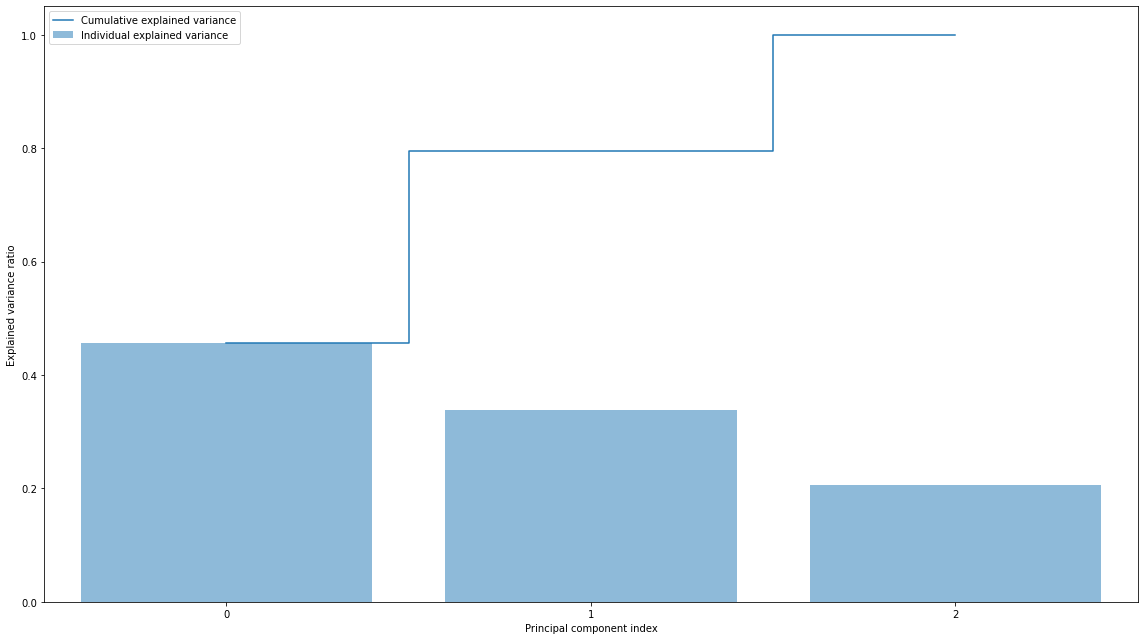

The cumulative variance of the first two principal components is 0.7947


In [36]:
# Padronização
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# criando objeto PCA
pca = PCA()

# aplicando PCA em features padronizadas
pca.fit(features_scaled)

# grafico que explica a variancia explicadas por cada componente
fig = plt.figure(figsize=(16,9))

plt.bar(range(0,len(exp_var_pca)),
        exp_var_pca, alpha=0.5,
        align='center',
        label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.xticks([0,1, 2, 3])
plt.xlim(-0.5,2.5)
plt.tight_layout()
plt.show()

# soma da variancia explicada pelos dois primeiros componentes
two_first_comp_var_exp = pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]
print("The cumulative variance of the first two principal components is {}".format(
    round(two_first_comp_var_exp, 5)))

## 7. Vizualizando os dois principais componentes
<p>Os dois primeiros componentes principais permitem a visualização dos dados em duas dimensões enquanto capturam uma alta proporção da variação (79%) de todos os três recursos: excesso de velocidade, influência do álcool e acidentes pela primeira vez. Isso nos permite usar nossos olhos para tentar discernir padrões nos dados com o objetivo de encontrar grupos de estados semelhantes. Embora os algoritmos de agrupamento estejam se tornando cada vez mais eficientes, o reconhecimento humano de padrões é um método de fácil acesso e muito eficiente de avaliar padrões em dados.</p>
<p>Criaremos um gráfico de dispersão dos primeiros componentes principais e exploraremos como os estados se agrupam nesta visualização.</p>

<AxesSubplot:>

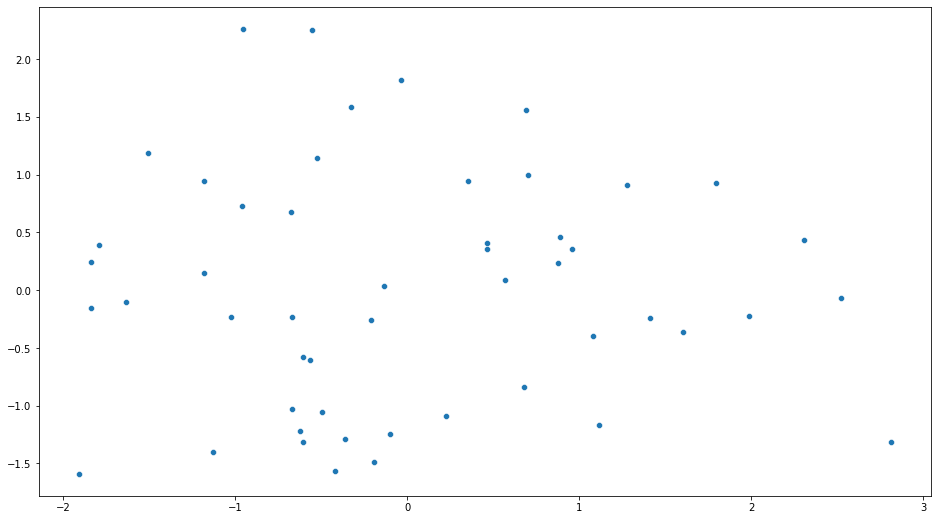

In [7]:
# aplicando PCA com apenas 2 componentes
pca = PCA(n_components=2)
p_comps = pca.fit_transform(features_scaled)

# extraindo o primeiro e segundo componente para plotagem
p_comp1 = p_comps[:,0]
p_comp2 = p_comps[:,1]

# Plotando os primeiros componentes
fig = plt.figure(figsize=(16,9))
sns.scatterplot(x=p_comp1,
                y=p_comp2)

## 8. Buscando estados semelhantes nos dados
<p>Não ficou totalmente claro no gráfico de dispersão do PCA em quantos grupos os estados se agrupam. Para ajudar na identificação de um número razoável de clusters, podemos usar o agrupamento do KMeans criando um scree plot e encontrando o "cotovelo", que é uma indicação de quando a adição de mais clusters não adiciona muito poder explicativo.</p>

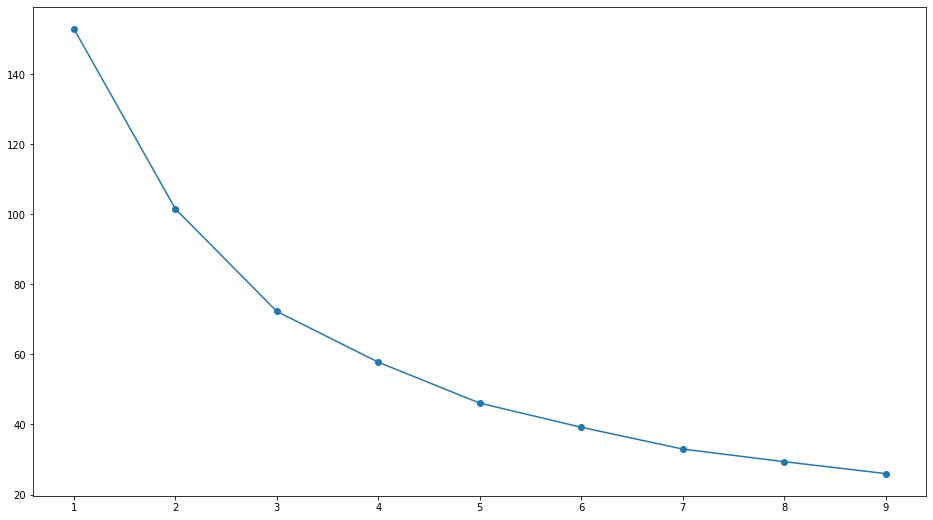

In [8]:
# criando um loop para testar ate 10 clusters etirar suas metricas
ks = range(1, 10)
inertias = []
for k in ks:
    # inicializando o KMeans com k clustues
    km = KMeans(n_clusters=k, random_state=8)
    # Treinamento do modelo
    km.fit(features_scaled)
    # adicionando a inercia do modleo na lista de inercias
    inertias.append(km.inertia_)
    
# plotando o resultado em uma line plot
fig = plt.figure(figsize=(16,9))
plt.plot(ks, inertias, marker='o');

## 9. KMeans para vizualizar o grafico com PCA aplicado
<p>Como não havia um cotovelo claro no scree plot, atribuir os estados a dois ou três clusters é uma escolha razoável, e retomaremos nossa análise usando três clusters. Vamos ver como fica o gráfico de dispersão do PCA se colorirmos os estados de acordo com o cluster ao qual eles são atribuídos.</p>

<AxesSubplot:>

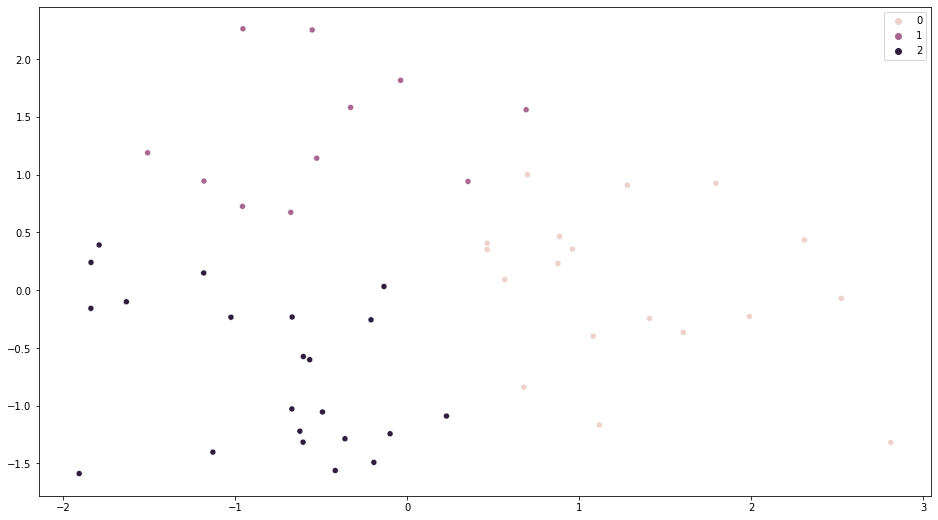

In [9]:
# criando um KMeans com 3 clusters 
km = KMeans(n_clusters=3, random_state=8)

# Treinamento do modelo
km.fit(features_scaled)

# plotagem dos clusters
fig = plt.figure(figsize=(16,9))
sns.scatterplot(x=p_comp1,
                y=p_comp2,
                hue=km.labels_)

## 10. Visualizando as diferenças entre clusters
<p>Até agora, usamos nossa interpretação visual dos dados e o algoritmo de agrupamento KMeans para revelar padrões nos dados, mas o que esses padrões significam?</p>
<p>Lembre-se que as informações que usamos para agrupar os estados em três grupos distintos são o percentual de motoristas em alta velocidade, sob efeito de álcool e que não se envolveram em acidente anteriormente. Usamos esses clusters para visualizar como os estados se agrupam ao considerar os dois primeiros componentes principais. Isso é bom para entendermos a estrutura dos dados, mas nem sempre é fácil de entender, especialmente se as descobertas forem comunicadas a um público não especializado.</p>
<p>Um próximo passo razoável em nossa análise é explorar como os três clusters são diferentes em termos dos três recursos que usamos para o clustering. Em vez de usar os recursos dimensionados, voltamos a usar os recursos não dimensionados para nos ajudar a interpretar as diferenças.</p>

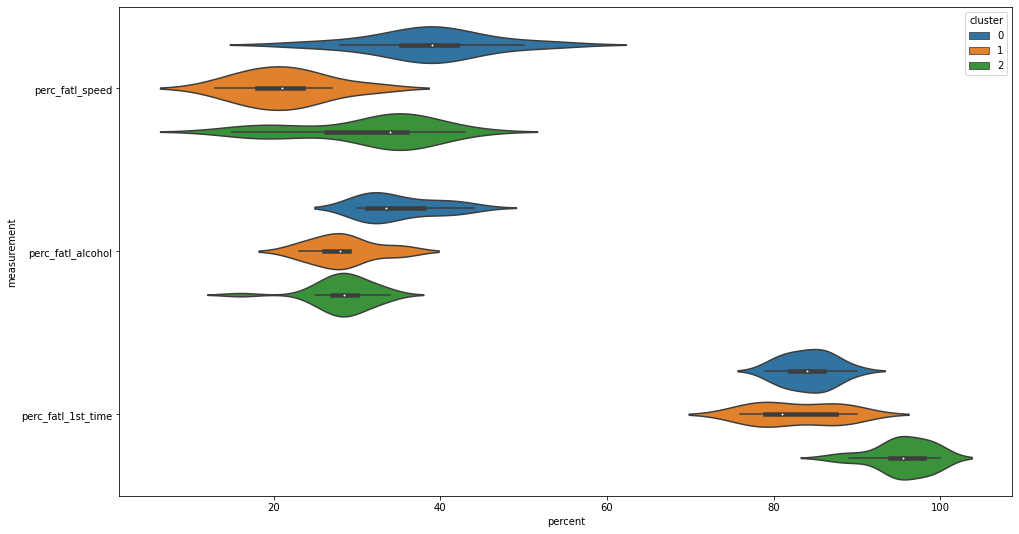

In [10]:
# criando uma nova coluna com o nome dos clusters
car_acc['cluster'] = km.labels_

# reshape no formato de dados long
melt_car = pd.melt(car_acc,
                   value_vars=['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time'],
                   id_vars='cluster',
                   var_name='measurement',
                   value_name='percent')

# craindo um grafico de violino pra vizualizarmos as dferenças
fig = plt.figure(figsize=(16,9))
sns.violinplot(data=melt_car,y='measurement',x='percent', hue='cluster');

## 11. Número de acidentes em cada Cluster
<p>Agora está claro que diferentes grupos de estados podem exigir diferentes intervenções. Como os recursos e o tempo são limitados, é útil começar primeiro com uma intervenção em um dos três grupos. Qual grupo seria este? Para determinar isso, incluiremos dados de quantos quilômetros são percorridos em cada estado, pois isso nos ajudará a calcular o número total de acidentes fatais em cada estado. Os dados sobre as milhas percorridas estão disponíveis em outro arquivo de texto delimitado por tabulação. Atribuiremos essas novas informações a uma coluna no DataFrame e criaremos um gráfico de violino para o número total de acidentes fatais de trânsito em cada estado.</p>

,count,mean,sum
cluster,,,
0,18,911.406439,16405.3159
1,11,860.505945,9465.5654
2,22,898.378595,19764.3291


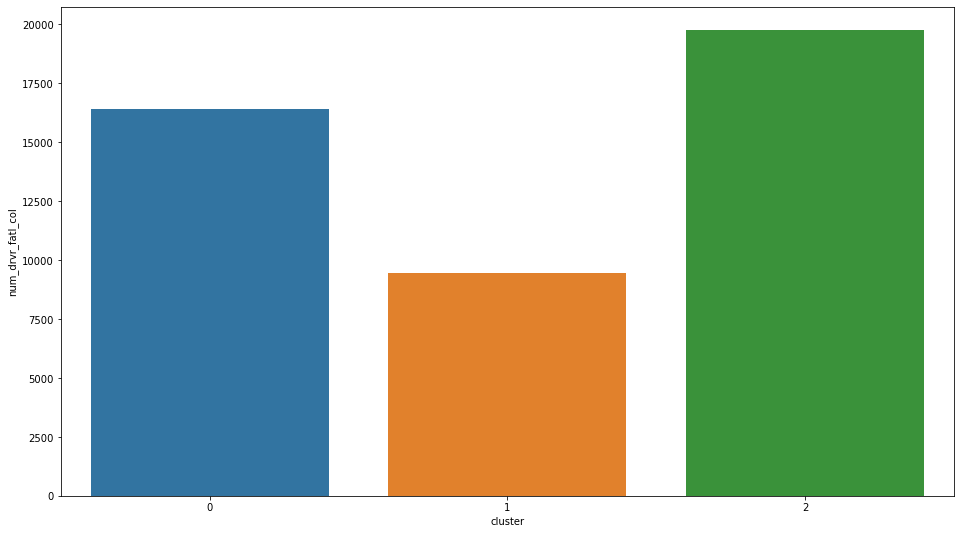

In [11]:
# lendo o novo dataset
miles_driven = pd.read_csv('miles-driven.csv', sep='|')

# juntando os dois datasets
car_acc_miles = car_acc.merge(miles_driven, on='state')

# Criando uma nova coluna com os numeros de acidentes
car_acc_miles['num_drvr_fatl_col'] = (car_acc_miles['million_miles_annually']/1000)*car_acc_miles['drvr_fatl_col_bmiles']

# criando uma coluna com o total de acidentes por clusters
fig = plt.figure(figsize=(16,9))
sns.barplot(x='cluster', y='num_drvr_fatl_col', data=car_acc_miles, estimator=sum, ci=None)

# Calculando a media a soma e a contagem de acidentes por cada cluster
count_mean_sum = car_acc_miles.groupby('cluster')['num_drvr_fatl_col'].agg(['count', 'mean', 'sum'])
count_mean_sum

## 12. Tomando uma decisção
<p>Como podemos ver, não há uma escolha óbvia e correta em relação a qual cluster é o mais importante para focar. No entanto, ainda podemos argumentar a favor de um determinado cluster e motivá-lo usando nossas descobertas acima.</p>